<a href="https://colab.research.google.com/github/albert-yue/gcn-explainability/blob/master/notebooks/experiment_20ng_fullmatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
%cd gdrive/My\ Drive/MIT/gcn_explainability/

/content/gdrive/My Drive/MIT/gcn_explainability


# Training

In [0]:
from src.data import Corpus, get_data, get_vocabulary, get_labels
from src.models.gcn import GCN
from src.preprocessing import clean_text, build_adj_matrix, normalize_adj
from src.train import train, evaluate

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
seed = 0
val_split = 0.1

vocab = get_vocabulary('data/20ng-vocabulary.txt')
labels = get_labels('data/20ng-labels.txt')
# corpus = get_data('data/train-20news.txt', labels)
# test_corpus = get_data('data/test-20news.txt', labels)

# # Split validation set
# corpus.shuffle(seed)
# len_train = int(len(corpus) * (1 - val_split))
# train_corpus = Corpus(corpus[:len_train])
# val_corpus = Corpus(corpus[len_train:])

# num_documents = len(train_corpus) + len(val_corpus) + len(test_corpus)
# print('Number of words, including <unk>:', len(vocab))
# print('Number of documents:', num_documents)

In [0]:
# Mask out unknown words
clean_text(train_corpus, vocab)
clean_text(val_corpus, vocab)
clean_text(test_corpus, vocab)

In [0]:
with open('data/train-20news-clean.txt', 'w+') as f:
    for doc in train_corpus:
        f.write(labels[doc.label])
        f.write('\t')
        f.write(' '.join(doc.text))
        f.write('\n')

In [0]:
with open('data/val-20news-clean.txt', 'w+') as f:
    for doc in val_corpus:
        f.write(labels[doc.label])
        f.write('\t')
        f.write(' '.join(doc.text))
        f.write('\n')

In [0]:
with open('data/test-20news-clean.txt', 'w+') as f:
    for doc in test_corpus:
        f.write(labels[doc.label])
        f.write('\t')
        f.write(' '.join(doc.text))
        f.write('\n')

In [9]:
corpus = get_data('data/train-20news-clean.txt', labels)
test_corpus = get_data('data/test-20news-clean.txt', labels)

# Split validation set
corpus.shuffle(seed)
len_train = int(len(corpus) * (1 - val_split))
train_corpus = Corpus(corpus[:len_train])
val_corpus = Corpus(corpus[len_train:])

num_documents = len(train_corpus) + len(val_corpus) + len(test_corpus)
print('Number of words, including <unk>:', len(vocab))
print('Number of documents:', num_documents)

Number of words, including <unk>: 61189
Number of documents: 18846


In [0]:
full_corpus = Corpus(corpus + test_corpus)

In [10]:
%time adj_matrix = build_adj_matrix(full_corpus, vocab, num_documents, doc_offset=0)

Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities



CPU times: user 49min 22s, sys: 19.5 s, total: 49min 41s
Wall time: 49min 26s


In [0]:
from src.utils import save_sparse_tensor

save_sparse_tensor(adj_matrix, 'data/20ng_full_adj_matrix.pt')

In [0]:
from src.utils import load_sparse_tensor

adj_matrix = load_sparse_tensor('data/20ng_full_adj_matrix.pt')

In [0]:
adj_matrix = normalize_adj(adj_matrix)

In [0]:
from src.utils import save_sparse_tensor

save_sparse_tensor(adj_matrix, 'data/20ng_full_adj_matrix_norm.pt')

In [0]:
from src.utils import load_sparse_tensor

adj_matrix = load_sparse_tensor('data/20ng_full_adj_matrix_norm.pt')

In [0]:
hidden_size = 200  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 200
lr = 0.02

num_vertices = len(vocab) + num_documents
model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)

In [0]:
print(num_vertices)

80035


In [11]:
%time train_losses, val_losses = train(model, adj_matrix, adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='gcn_20ng_full.pt')
print(train_losses)
print(val_losses)

Epoch 0
Train mean cross-entropy: 2.995774269104004
Validation mean cross-entropy: 2.97629451751709
Epoch 10
Train mean cross-entropy: 2.3573367595672607
Validation mean cross-entropy: 2.2803151607513428
Epoch 20
Train mean cross-entropy: 1.2004448175430298
Validation mean cross-entropy: 1.1881967782974243
Epoch 30
Train mean cross-entropy: 0.5415611863136292
Validation mean cross-entropy: 0.6249483227729797
Epoch 40
Train mean cross-entropy: 0.2994822561740875
Validation mean cross-entropy: 0.4358520209789276
Epoch 50
Train mean cross-entropy: 0.19358155131340027
Validation mean cross-entropy: 0.3640200197696686
Epoch 60
Train mean cross-entropy: 0.13613639771938324
Validation mean cross-entropy: 0.3296133577823639
Epoch 70
Train mean cross-entropy: 0.09852118045091629
Validation mean cross-entropy: 0.3164965510368347
Epoch 80
Train mean cross-entropy: 0.07574781030416489
Validation mean cross-entropy: 0.31203314661979675
Epoch 90
Train mean cross-entropy: 0.05982712656259537
Validati

In [0]:
from matplotlib import pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.title("20NG Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend(loc='lower left')

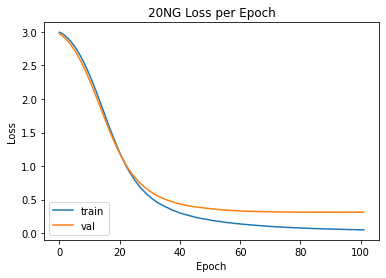

In [13]:
plot_loss(train_losses, val_losses)

In [0]:
from sklearn.metrics import accuracy_score
import torch

def accuracy(preds, targets):
    label_preds = torch.argmax(preds, dim=-1).detach().numpy()
    return accuracy_score(targets, label_preds)

In [15]:
test_start_idx = len(vocab) + len(train_corpus) + len(val_corpus)
test_loss = evaluate(model, adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
print(test_loss)

0.858072225172597


In [14]:
import torch

model_reloaded = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)
model_reloaded.load_state_dict(torch.load('gcn_20ng_full.pt'))
test_start_idx = len(vocab) + len(train_corpus) + len(val_corpus)
test_loss = evaluate(model_reloaded, adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
print(test_loss)

0.858072225172597


In [19]:
model_reloaded

GCN(
  (dropout): Dropout(p=0.5, inplace=False)
  (act_func): ReLU()
  (softmax): LogSoftmax()
  (layer1): GraphConv(input_size=80035, output_size=200)
  (layer2): GraphConv(input_size=200, output_size=20)
)

In [56]:
import numpy as np

model_reloaded.eval()
with torch.no_grad():
    preds = model_reloaded(adj_matrix)

# for i in range(1, len(test_corpus)):
count = 0
for i in range(1, len(test_corpus)):
    if test_corpus.data[-i].label == np.argmax(preds[-i, :].detach().numpy()):
        count += 1
print(count/len(test_corpus))

0.858072225172597
